In [1]:
import pandas as pd

import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, date

p28 Questions

1. What's the similarity and difference between:
    
    a) a long call and a short put?
    
    Similarity: 
    - **both holders are bullish**

   Difference:
    - lc pays premium
    - sp receives premium
    - lc max profit = unlimited
    - sp max profit = premium
    - lc max loss = premium
    - sp max loss = unlimited
    - **sp is riskier**
    
   b) a long put and a short call?
    
    Similarity: 
    - **both holders are bearish**

   Difference:
    - lp pays premium
    - sc receives premium
    - lp max profit = unlimited
    - sc max profit = premium
    - lp max loss = premium
    - sc max loss = unlimited
    - **sc is riskier**
    
**shorts are always riskier**

2. A lc provides downside protection, while a lp provides upside protection. True or False? Why?

Lp provides downside protection acting as a stop-loss at strike level (minus premium, ie breakeven point). Lc holder will exit at breakeven point, which might be higher than the market. Lc provides upside protection - via purchasing a right to enter long position in underlying at a stike (plus premium, breakeven), which might be lower than the market. 

So answer is **False**, they confused the two. 

3. Boeing is currently trading at 36, and the May 35 puts are trading at 3 1/8. 

a) If you buy one if these puts at the current market price, what is your break-even level? lp_bre = strike - premium = 35 - 3.125 = 31.875

b) lp_max_gain = inf

c) lp_max_loss = premium = 3.125

d) 
   - sp_bre = lp_bre = 31.875
   - sp_max_gain = premium = 3.125
   - sp_max_loss = inf
   
e) If you sell one of these puts at the current market price, what is the potentnial effective purchase price of the stock at expiration? und_price - premium = 36 - 3.125 = 32.875

f) The multiplier for this options contract is 100. What's the cash value of one of these puts? premium * cash_mult = 3.125 * 100 = $312.5

g) If at May expiration Boeing closes at 30, what is the profit for the put buyer, and what's the loss for put seller?
    
    - lp_total_prft = (strike - und_price - premium) * cash_mult = (35 - 30 - 3.125) * 100 = 187.5
    - sp_total_loss = -lp_total_prft = -187.5 or (und_price + premium - strike) * cash_mult = (30 + 3.125 - 35) * 100

In [151]:
# profit_loss_table
def lp_pl(price, strike, premium):
    """
    Long put profit loss
    """
    if price <= strike:
        return (strike - price - premium) 
    return - premium

def lp_max_gain():
    """
    Long put maximum gain
    """
    return np.inf

def lp_max_loss(premium):
    """
    Long put maximum loss
    """
    return -premium

def sp_pl(price, strike, premium):
    """
    Short put profit loss
    """
    return -lp_pl(price, strike, premium)

def sp_max_gain(premium):
    """
    Short put maximum gain
    """
    return premium

def sp_max_loss(strike, premium):
    """
    Short put maximum loss per 1 unit of underlying
    """
    return premium - strike

def put_value_at_exp(price, strike, premium):
    """
    Value of put at expiration
    """
    if price >= strike:
        return 0
    return price - strike

def put_pl(ticker, strike, premium, cash_mult, und_price=False, plot=False, prices=None, figsize=(17,2)):
    
    # basics
    breakeven = strike - premium
    basis = strike - breakeven
    absbasis = np.abs(basis)
    lp_maxloss = lp_max_loss(premium)
    sp_maxgain = sp_max_gain(premium)
    
    if und_price is False:
        und_price = breakeven
        
    lp_pnl = lp_pl(und_price, strike, premium)
    sp_pnl = -lp_pnl
    
    
    
    # let's be consistent for calls and puts. x-axis (prices) increase rightbound, decrease leftbound
    delta = (und_price-strike)/strike
    delta_beven = (und_price-breakeven)/breakeven
    
    cash_value = premium * cash_mult
    lp_total_prft = None
    sp_total_prft = None
    
    if und_price is not False:
        lp_total_prft = (strike - und_price - premium) * cash_mult
        sp_total_prft = -lp_total_prft
        
    # x ticks of appropriate size - I take delta as basis to make plot visually easier
    if prices is None:
        # if price is too far to the right 
        # TODO - I need a better scaling und_price * 1.01
        end = breakeven+(absbasis*1.5) if breakeven+(absbasis*1.5) > und_price else und_price * 1.01
        if und_price <= strike:
            # let's not have negative underlying prices, it's unbecoming...
            start = 0 if und_price-(absbasis*1.5) < 0 else und_price-(absbasis*1.5)
            prices = np.arange(start, 
                               end, 
                               absbasis*.1)
        else: 
            start = 0 if strike-(absbasis*1.5) < 0 else strike-(absbasis*1.5)            
            prices = np.arange(start, 
                               end, 
                               absbasis*.1)
    # add breakeven
    prices = np.sort(np.append(prices, breakeven))
    print(prices[-1])
        
    long = [(price, 
             put_value_at_exp(price, strike, premium),
             lp_pl(price, strike, premium),
             lp_max_gain(),
             lp_max_loss(premium)) for price in prices]
    short = [(price, 
              put_value_at_exp(price, strike, premium),
              sp_pl(price, strike, premium),
              sp_max_gain(premium),
              sp_max_loss(strike, premium)) for price in prices]
    
    
    if plot == True:
        fig, ax = plt.subplots(figsize=figsize)
    
        short_pls = [pl for (price, val, pl, maxgain, maxloss) in short]
        long_pls = [pl for (price, val, pl, maxgain, maxloss) in long]
        
        # print short pl 
        ax.plot(prices, short_pls, 'r', linewidth=.75, label='short PL')
        
        # print long pl 
        ax.plot(prices, long_pls, 'g', linewidth=.75, label='long PL')
        
        # zero price line
        # ax.plot(prices, np.zeros(len(prices)), 'k--', linewidth=.75)
        
        # current underlying price
        ax.plot([und_price]*3, [-premium*1.5,0,premium*1.5], 'y-', linewidth=.75, label=f'price {und_price}')
        
        # strike reference
        ax.plot([strike]*3, [-premium*1.5,0,premium*1.5], 'k--', linewidth=.75, label=f'strike {strike}')
        
        # styling
        plt.title(f'Put positions in {ticker.upper()}')
        plt.xlabel(f'{ticker.upper()} Price')
        plt.ylabel('Profit and Loss')
        plt.legend()
        plt.xticks(rotation=45)
        plt.xticks([prices[0], breakeven, und_price, strike, prices[-1]],
                    [f'{prices[0]:.2f}', f'{breakeven:.2f}', f'{und_price:.2f}', f'{strike:.2f}', f'{prices[-1]:.2f}'])
        
        # y ticks and labels
        # I need to show pls for current prices, max loss/gains
        if und_price < 0:
            yticks = [lp_maxloss, lp_pnl, 0, sp_pnl, sp_maxgain]
            ytickslabels = [f'{lp_maxloss:.2f}', f'{lp_pnl:.2f}', f'{0}', f'{sp_pnl:.2f}', f'{sp_maxgain:.2f}']  
        else: 
            ytickslabels = [f'{lp_maxloss:.2f}', f'{sp_pnl:.2f}', f'{0}', f'{lp_pnl:.2f}', f'{sp_maxgain:.2f}']
            yticks = [lp_maxloss, sp_pnl, 0, lp_pnl, sp_maxgain]
        
        
        plt.yticks(yticks, ytickslabels)
        
        # styling
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.spines['left'].set_visible(False)
        ax.spines['bottom'].set_color('#DDDDDD')
        ax.tick_params(bottom=False, left=False)
        ax.set_axisbelow(True)
        ax.yaxis.grid(True, color='#AAAAAA')
        ax.xaxis.grid(False)

#     if und_price == False:
#         return (long, short, breakeven, delta, delta_beven, cash_value)
    return (long, short, breakeven, delta, delta_beven, cash_value, lp_total_prft, sp_total_prft)

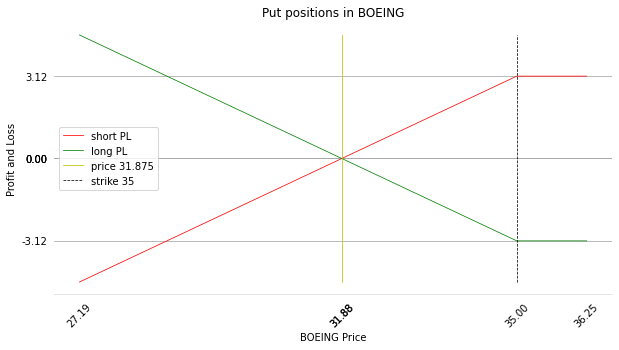

In [100]:
# 3 Boeing
ticker = 'Boeing'
prices = [25, 30, 31, 31.875, 32, 33, 34, 35, 40]
und_price = 30
strike = 35
premium = 3.125
cash_multiplier = 100
stl_price = 30
long, short, breakeven, delta, delta_beven, cash_value, lp_total_prft, sp_total_prft = put_pl(ticker, strike, 
                                                                                            premium, 
                                                                                            cash_multiplier, 
#                                                                                             und_price, 
                                                                                            plot=True, 
#                                                                                             prices=prices,
                                                                                            figsize=(10,5))
# print(long)
# print(lp_total_prft, sp_total_prft)
# print(long)
# print(delta)
# print(delta_beven)
# print(cash_value)

-3.25


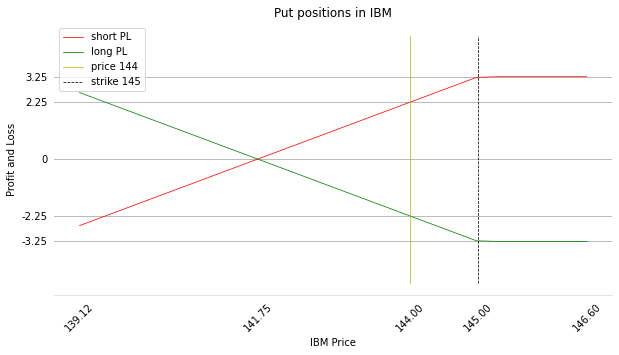

In [90]:
# 4 IBM
ticker = 'IBM'
prices = [25, 30, 31, 31.875, 32, 33, 34, 35, 40]
und_price = 144
strike = 145
premium = 3.25
cash_multiplier = 100
stl_price = 135
long, short, breakeven, delta, delta_beven, cash_value, lp_total_prft, sp_total_prft = put_pl(ticker, strike, 
                                                                                            premium, 
                                                                                            und_price, 
                                                                                            cash_multiplier, 
                                                                                            stl_price, 
                                                                                            plot=True, 
#                                                                                             prices=prices,
                                                                                            figsize=(10,5))
# print(long) # (price, val, pl, maxgain, maxloss)
# print(short)
# print(lp_total_prft, sp_total_prft)
# print(delta)
# print(delta_beven)
# print(cash_value)

[(460.0, -40.0, 22.625, inf, -17.375), (470.0, -30.0, 12.625, inf, -17.375), (480.0, -20.0, 2.625, inf, -17.375), (482.625, -17.375, 0.0, inf, -17.375), (490.0, -10.0, -7.375, inf, -17.375), (500.0, 0, -17.375, inf, -17.375), (510.0, 0, -17.375, inf, -17.375)]


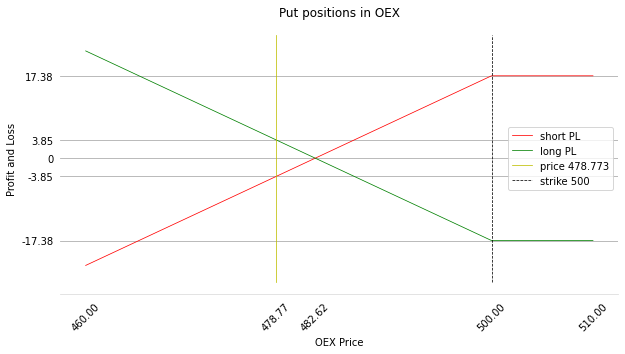

In [127]:
# 5 OEX
prices = np.arange(460, 520, 10)
ticker = 'OEX'
und_price = 531.97*.9 #531.97
strike = 500
premium = 17+3/8
cash_multiplier = 100
_ = put_pl(ticker, strike, premium, cash_multiplier, und_price, plot=True, prices=prices, figsize=(10,5))
print(_[0])

In [132]:
# pss, mate, wanna a bit trigonometry?
# knowing that y/x = tg 45 = 1 (because we get 1 for 1 - moving left off strike lp gains 1 for 1 loss sp)
500 - 478.77 # adjacent (price) = 21.23 units => opposite (pnl) = also +21.23 from its beginning (-17.38)
# now scale y
-17.38 + 21.23

3.8500000000000014

[(370, -50, 11, inf, -39), (380, -40, 1, inf, -39), (381, -39, 0, inf, -39), (390, -30, -9, inf, -39), (400, -20, -19, inf, -39), (410, -10, -29, inf, -39), (420, 0, -39, inf, -39), (430, 0, -39, inf, -39), (440, 0, -39, inf, -39)]


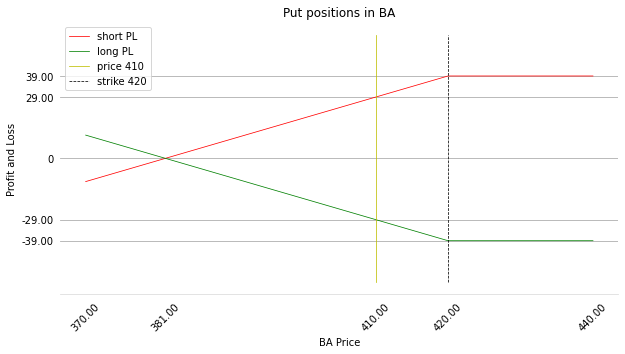

In [133]:
# 6 BA
prices = np.arange(370, 450, 10)
ticker = 'BA'
und_price = 410
strike = 420
premium = 39
cash_multiplier = 1000
_ = put_pl(ticker, strike, premium, cash_multiplier, und_price, plot=True, prices=prices, figsize=(10,5))
print(_[0])

131.0843750000001


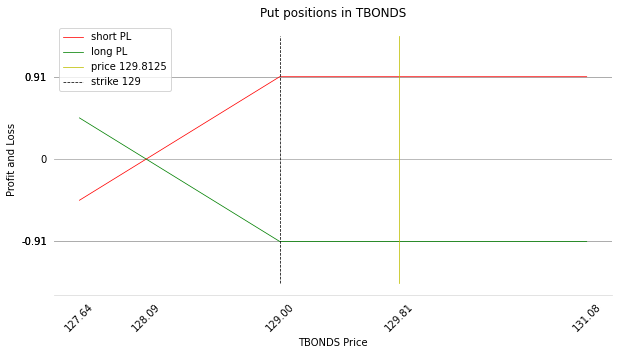

In [155]:
# 7 TBonds - NOT ACCURATE AS FUTURES ARE TRADED IN TICKS OF 32 == 1.00 = 32/32 AND OPTIONS ARE HALF OF THAT == 64/64
# mind melting
# prices = np.arange(370, 450, 10)
ticker = 'TBonds'
und_price = 129 + 26/32 # 129.8125
strike = 129
premium = 58/64 # 0.90625
cash_multiplier = 1000
_ = put_pl(ticker, strike, premium, cash_multiplier, und_price, plot=True, 
#            prices=prices, 
           figsize=(10,5))
# print(_[0])

358.50000000000057


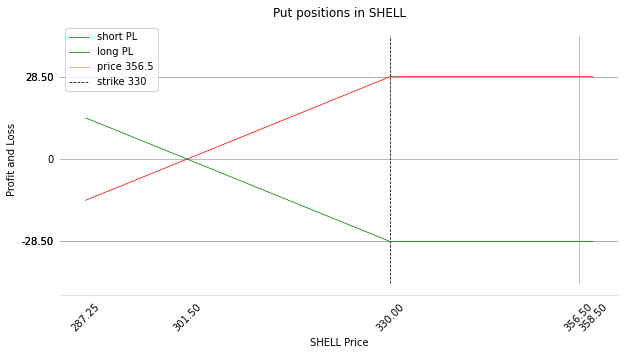

In [157]:
# 8 Shell
prices = np.arange(370, 450, 10)
ticker = 'Shell'
und_price = 356.5
strike = 330
premium = 28.5
cash_multiplier = 1000
_ = put_pl(ticker, strike, premium, cash_multiplier, und_price, plot=True, 
           #prices=prices, 
           figsize=(10,5))

In [158]:
356.5 + 28.5

385.0

In [166]:
# c
# potential savings from purchase of shares if assigned == und_price -(strike - premium)
savings = und_price -(strike - premium)
print(savings) # 55
high_price = 499.5
op_cost = high_price - und_price
print(op_cost) # 143
savings/op_cost

55.0
143.0


0.38461538461538464

In [167]:
# d
385-premium # 356.5

356.5

In [168]:
# e 
# average cost of sales
# bought 1000 at und_price, and was assigned (it's assumed) 1000 shares per Apr 330 contract
(und_price + strike - premium) / 2

329.0